## Replication code for
# The Political Economy of Monetary Financing without Inflation
### Gregor Boehl

First, install the necessary packages. Do this either here (uncomment the cell below) or with your prefered package manager.

In [1]:
#!pip install econpizza
#!pip install grgrlib#
#!pip install tqdm

The documentation for the EP package, which is used for the simulations in the paper, can be found [here](https://econpizza.readthedocs.io/en/stable/index.html).

Do some imports:

In [2]:
# imports
import jax
import jax.numpy as jnp
import tqdm
import matplotlib.pyplot as plt
import econpizza as ep
from econpizza.tools import anneal_stst
from grgrlib import print_dict, pplot, figurator
from scipy import interpolate, optimize

# plotting setup
plt.rc('text', usetex=True)

# if you run this in a jupyter notebook:
%matplotlib inline

The YAML file which contains the two-asset HANK model is hosted as part of the example models for EP: https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank2.yml

All the models from the paper, and some others, are included: https://github.com/gboehl/econpizza/tree/master/econpizza/examples

That means, if you are on econpizza version 0.6.8 and above, the model for this exercise is included in the examples. You can simply do:

In [3]:
path_yaml = ep.examples.hank_banking

If you are on econpizza version 0.6.7 and below, you have to take the rocky road:

In [4]:
import requests
import tempfile
import os

url_yaml = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank_banking.yml"
url_funcs = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank_banking_functions.py"

# download yaml
dl_yaml = requests.get(url_yaml)
dl_funcs = requests.get(url_funcs)

# write content to temporary directory
tmpdir = tempfile.TemporaryDirectory()
tmpdirname = tmpdir.name

path_yaml = os.path.join(tmpdirname, 'hank_banking.yaml')
path_funcs = os.path.join(tmpdirname, 'hank_banking_functions.py')

with open(path_yaml, 'wb') as f:
    f.write(dl_yaml.content)

with open(path_funcs, 'wb') as f:
    f.write(dl_funcs.content)

## Figure 4 
The number of parameter value variations per plot in the paper is `50`. To speed things up, I here go for `10`.

In [5]:
# from the paper
n = 50
# faster
n = 10

The simulations in Figure B.12 in Appendix B are identical, `tax_distortion` is set to `False`.

In [6]:
tax_distortion = True

In [7]:
# parse model
mod_dict = ep.parse(path_yaml)
mod_dict['globals']['tax_distortion'] = tax_distortion

# compile model
mod = ep.load(mod_dict, raise_errors=True)
_ = mod.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.60e+00 | lapsed 3.4133
    Iteration   2 | max. error 4.45e-02 | lapsed 5.3997
    Iteration   3 | max. error 6.58e-04 | lapsed 7.1883
(solve_stst:) Steady state found (9.1775s). The solution converged.


In [8]:
# fix some steady state values
mod_dict['steady_state']['init_guesses']['Rj'] = mod_dict['steady_state']['fixed_values']['Rj']
mod_dict['steady_state']['init_guesses']['g2y'] = mod_dict['steady_state']['fixed_values']['g2y']
mod_dict['steady_state']['init_guesses']['seig2y'] = mod_dict['steady_state']['fixed_values']['seig2y']
mod_dict['steady_state']['init_guesses']['bprof'] = mod_dict['steady_state']['fixed_values']['bprof']
mod_dict['steady_state']['init_guesses']['y'] = mod_dict['steady_state']['fixed_values']['y']
del mod_dict['steady_state']['fixed_values']['Rj']
del mod_dict['steady_state']['fixed_values']['g2y']
del mod_dict['steady_state']['fixed_values']['seig2y']
del mod_dict['steady_state']['fixed_values']['MPJ']
del mod_dict['steady_state']['fixed_values']['bprof']
del mod_dict['steady_state']['fixed_values']['bcost2y']
del mod_dict['steady_state']['fixed_values']['y']

mod_dict['steady_state']['fixed_values']['MPJ'] = 0
mod_dict['steady_state']['fixed_values']['gamma_log'] = mod.pars['gamma_log']
mod_dict['steady_state']['fixed_values']['nu_log'] = mod.pars['nu_log']
mod_dict['steady_state']['fixed_values']['div2equity'] = mod.pars['div2equity']
mod_dict['steady_state']['fixed_values']['g'] = mod.stst['g']
mod_dict['steady_state']['fixed_values']['omega'] = mod.pars['omega']
mod_dict['steady_state']['fixed_values']['z'] = mod.stst['z']

In [9]:
# iterate over range
xs = jnp.linspace(1,10,n)

# initialize
dist = mod['steady_state']['distributions'][0]
values = mod['steady_state']['value_functions'][0]
stst = mod.stst.values()
res = ()

for x in tqdm.tqdm(xs):

    mod_dict['steady_state']['fixed_values']['Jex'] = x
    # use last result as guess
    mod_dict['steady_state']['init_guesses'].update(mod['steady_state']['found_values'])

    # compile model
    mod = ep.load(mod_dict, raise_errors=True, verbose=False)
    # find steady state
    res_stst = mod.solve_stst(tol=1e-8, maxit=30, tol_forwards=1e-11, verbose=False)

    # store
    dist = mod['steady_state']['distributions'][0]
    values = mod['steady_state']['value_functions'][0]
    stst = mod.stst.values()

    res += (stst, dist, values),

100%|██████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.18s/it]


In [10]:
# extract values
bins, values_ut = (), ()
for x in res:
    binned_weight = x[1].sum(0).cumsum()
    binned_values = (x[1]*x[2]).sum(0).cumsum()
    bins_aggr = jnp.interp(jnp.linspace(0,1,4)[1:], binned_weight, binned_values)
    bins += jnp.diff(bins_aggr, prepend=0)*3,
    values_ut += jnp.sum(x[1]*x[2]),

bins = jnp.array(bins).T
stst = jnp.array([[*x[0]] for x in res])

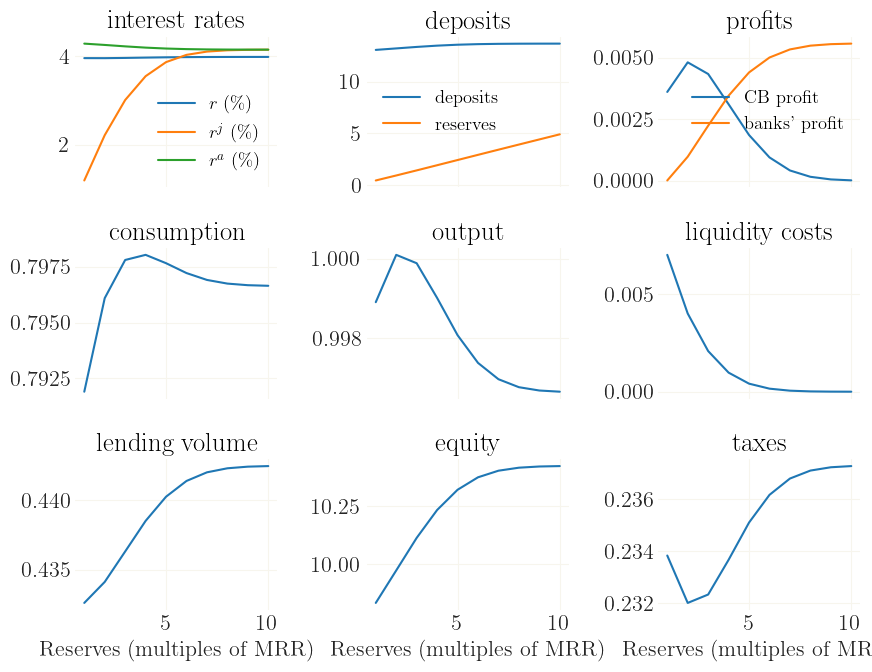

In [11]:
# plotting
fig, axs = plt.subplots(3, 3, figsize=(9,7), sharex='col')
axs[0,0].set_title('interest rates')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('R')]-1)*400, label='$r$ (\\%)')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('Rj')]-1)*400, label='$r^j$ (\\%)')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('Ra')]-1)*400, label='$r^a$ (\\%)')
axs[0,0].legend(framealpha=0)
axs[0,1].set_title('deposits')
axs[0,1].plot(xs, stst[:,mod.var_names.index('depos')], label='deposits')
axs[0,1].plot(xs, stst[:,mod.var_names.index('J')], label='reserves')
axs[0,1].legend(framealpha=0)
axs[0,2].set_title("profits")
axs[0,2].plot(xs, stst[:,mod.var_names.index('seig')], label='CB profit')
axs[0,2].plot(xs, stst[:,mod.var_names.index('bprof')], label="banks' profit")
axs[0,2].legend(framealpha=0)
axs[1,0].set_title('consumption')
axs[1,0].plot(xs, stst[:,mod.var_names.index('C')])
axs[1,1].set_title('output')
axs[1,1].plot(xs, stst[:,mod.var_names.index('y')])
axs[1,2].set_title('liquidity costs')
axs[1,2].plot(xs, stst[:,mod.var_names.index('bcost')])
axs[2,0].set_title('lending volume')
axs[2,0].plot(xs, stst[:,mod.var_names.index('borr')])
axs[2,1].set_title('equity')
axs[2,1].plot(xs, stst[:,mod.var_names.index('equity')])
axs[2,2].set_title('taxes')
axs[2,2].plot(xs, stst[:,mod.var_names.index('tax')])
axs[2,0].set_xlabel('Reserves (multiples of MRR)')
axs[2,1].set_xlabel('Reserves (multiples of MRR)')
axs[2,2].set_xlabel('Reserves (multiples of MRR)')
fig.tight_layout()

In [12]:
# get maximum
tck = interpolate.splrep(xs, jnp.array(values_ut))
imax = jnp.argmax(jnp.array(values_ut))

fun = lambda x: -interpolate.splev(x, tck)
res = optimize.minimize_scalar(fun, (xs[imax-1], xs[imax+1]))

print('optimum: ', res.message)
print('value: ', res.x)

optimum:  
Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 1.48e-08 )
value:  2.834195317696041


## Figure 5
The figure uses the same simulations.

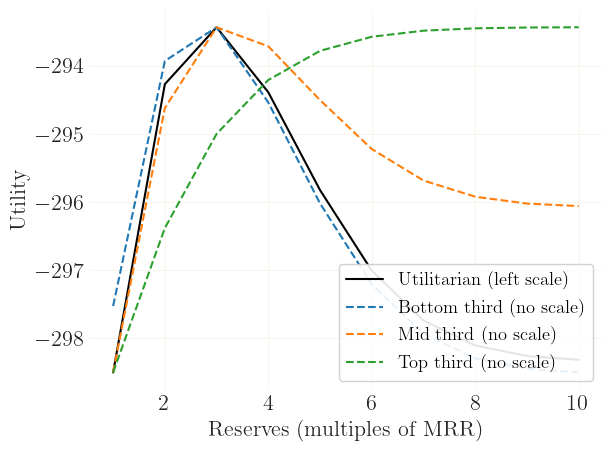

In [13]:
# plot
fig, ax = plt.subplots()
lns = ax.plot(xs, values_ut, c='k', label='Utilitarian (left scale)')[0],
legends = 'Bottom third (no scale)', 'Mid third (no scale)', 'Top third (no scale)'
for i,line in enumerate(bins):
    axx = ax.twinx()
    lns += axx.plot(xs, line, '--', c=f'C{i}', label=legends[i])[0],
    axx.set_yticks([])
ax.set_xlabel('Reserves (multiples of MRR)')
ax.set_ylabel('Utility')
axx.legend(lns, [l.get_label() for l in lns], loc=4, framealpha=.9)
fig.tight_layout()
fig.savefig('/home/gboehl/rsh/xrs/figs/welfare_exs' + tax_distortion*'_distort')

## Figure 6
For the figure, it is necessary to calculate the transition dynamics between two steady states. For that purpuse, start with two fresh models.

In [14]:
# parse model
mod_dict = ep.parse(path_yaml)
mod_dict['globals']['tax_distortion'] = tax_distortion

# compile calibrated model & find stst
mod_clb = ep.load(mod_dict, raise_errors=True)
_ = mod_clb.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.60e+00 | lapsed 3.5299
    Iteration   2 | max. error 4.45e-02 | lapsed 5.3574
    Iteration   3 | max. error 6.58e-04 | lapsed 7.2527
(solve_stst:) Steady state found (9.2799s). The solution converged.


In [15]:
# fix some steady state values
mod_dict['steady_state']['init_guesses']['Rj'] = mod_dict['steady_state']['fixed_values']['Rj']
mod_dict['steady_state']['init_guesses']['g2y'] = mod_dict['steady_state']['fixed_values']['g2y']
mod_dict['steady_state']['init_guesses']['seig2y'] = mod_dict['steady_state']['fixed_values']['seig2y']
mod_dict['steady_state']['init_guesses']['bprof'] = mod_dict['steady_state']['fixed_values']['bprof']
mod_dict['steady_state']['init_guesses']['y'] = mod_dict['steady_state']['fixed_values']['y']
del mod_dict['steady_state']['fixed_values']['Rj']
del mod_dict['steady_state']['fixed_values']['g2y']
del mod_dict['steady_state']['fixed_values']['seig2y']
del mod_dict['steady_state']['fixed_values']['MPJ']
del mod_dict['steady_state']['fixed_values']['bprof']
del mod_dict['steady_state']['fixed_values']['bcost2y']
del mod_dict['steady_state']['fixed_values']['y']

mod_dict['steady_state']['fixed_values']['MPJ'] = 0
mod_dict['steady_state']['fixed_values']['gamma_log'] = mod_clb.pars['gamma_log']
mod_dict['steady_state']['fixed_values']['nu_log'] = mod_clb.pars['nu_log']
mod_dict['steady_state']['fixed_values']['div2equity'] = mod_clb.pars['div2equity']
mod_dict['steady_state']['fixed_values']['g'] = mod_clb.stst['g']
mod_dict['steady_state']['fixed_values']['omega'] = mod_clb.pars['omega']
mod_dict['steady_state']['fixed_values']['rho_j'] = 0.9
mod_dict['steady_state']['fixed_values']['z'] = mod_clb.stst['z']

In [16]:
# compile initial model & find stst
mod_dict['steady_state']['fixed_values']['Jex'] = 20
mod_ini = ep.load(mod_dict, raise_errors=True)
_ = mod_ini.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.90e+01 | lapsed 3.8551
    Iteration   2 | max. error 2.09e+00 | lapsed 5.7965
    Iteration   3 | max. error 2.99e-01 | lapsed 7.7455
    Iteration   4 | max. error 1.21e-02 | lapsed 9.6175
    Iteration   5 | max. error 4.25e-05 | lapsed 11.5427
(solve_stst:) Steady state found (13.443s). The solution converged.


In [17]:
# compile target model & find stst
mod_dict['steady_state']['fixed_values']['Jex'] = 2.8331129901417342
mod_tgt = ep.load(mod_dict, raise_errors=True)
_ = mod_tgt.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.83e+00 | lapsed 3.5056
    Iteration   2 | max. error 5.48e-02 | lapsed 5.3496
    Iteration   3 | max. error 1.79e-02 | lapsed 7.3343
    Iteration   4 | max. error 4.85e-06 | lapsed 9.2156
(solve_stst:) Steady state found (11.06s). The solution converged.


In [18]:
# define shocks/initial state
x0 = mod_ini['stst'].copy()
x1 = mod_tgt['stst'].copy()
dist_ini = mod_ini['steady_state']['distributions']

# simulate
horizon = 200
xst, flags = mod_tgt.find_path(init_state=x0.values(), 
                               init_dist=dist_ini, 
                               horizon=horizon, 
                               tol=1e-8, 
                               use_solid_solver=False, 
                               nsteps=30, 
                               maxit=300, 
                               relaxation=0.2)

xstst_ini = jnp.ones_like(xst)*ep.parser.d2jnp(x0)
xstst_tgt = jnp.ones_like(xst)*ep.parser.d2jnp(x1)

(get_derivatives:) Derivatives calculation done (8.002s).
(get_jacobian:) Jacobian accumulation and decomposition done (6.379s).
    Iteration  1 | fev.  30 | error 1.37e+01 | inner 3.72e+01 | dampening 0.764
    Iteration  2 | fev.  60 | error 1.20e+01 | inner 3.67e-01 | dampening 0.279
    Iteration  3 | fev.  90 | error 9.63e+00 | inner 1.15e+00 | dampening 0.432
    Iteration  4 | fev. 120 | error 7.95e+00 | inner 1.71e-02 | dampening 0.490
    Iteration  5 | fev. 150 | error 6.50e+00 | inner 4.36e-05 | dampening 0.469
    Iteration  6 | fev. 179 | error 5.27e+00 | inner 3.57e-06 | dampening 0.485
    Iteration  7 | fev. 209 | error 4.26e+00 | inner 7.61e-05 | dampening 0.590
    Iteration  8 | fev. 239 | error 3.43e+00 | inner 3.63e-06 | dampening 0.613
    Iteration  9 | fev. 263 | error 2.76e+00 | inner 4.80e-06 | dampening 0.604
    Iteration 10 | fev. 286 | error 2.22e+00 | inner 7.76e-06 | dampening 0.630
    Iteration 11 | fev. 312 | error 1.78e+00 | inner 5.99e-06 | dampeni

In [19]:
# get values for CEVs
a_grid = mod_ini['context']['a_grid']
e_stat = mod_ini['context']['skills_stationary']
values_stst_ini = mod_ini['steady_state']['value_functions'][0]
dist = mod_ini['steady_state']['distributions'][0]
het = mod_tgt.get_distributions(xst, init_dist=dist_ini)
values = het['VPrime'][...,0]

# calculate consumption equivalent variation per CDF
nbins = 20
cev = 100*((values/values_stst_ini)**(1/(1-mod_ini.pars['sigma_c'])) - 1)
cev_a = jnp.sum(cev*e_stat[:,None], 0)
dist_a = jnp.sum(dist, 0)
bins = jnp.linspace(0,1,nbins)
cev_in_bins = jnp.diff(jnp.interp(bins[1:], dist_a.cumsum(), (dist_a*cev_a).cumsum()), prepend=0)*nbins

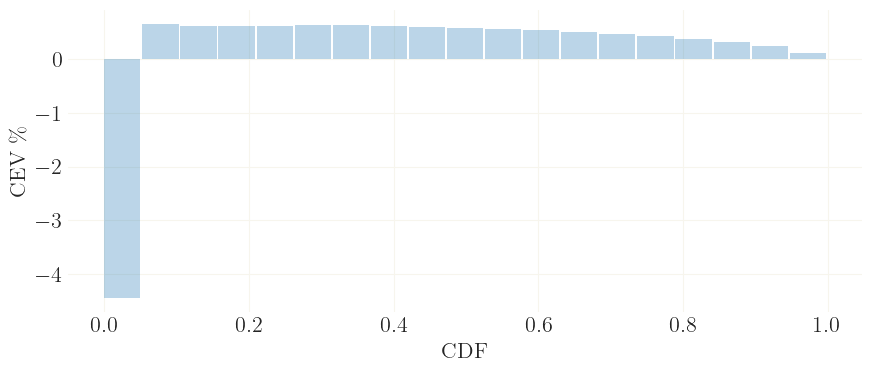

In [20]:
# plot difference in utilities
fig, axs = plt.subplots(figsize=(9,4))
axs.bar(bins[:-1], cev_in_bins, width=1/nbins, alpha=0.3, align='edge')
axs.set_xlabel('CDF')
axs.set_ylabel('CEV \\%')
fig.tight_layout()

This can be used to create Figure B.11 from Appendix B

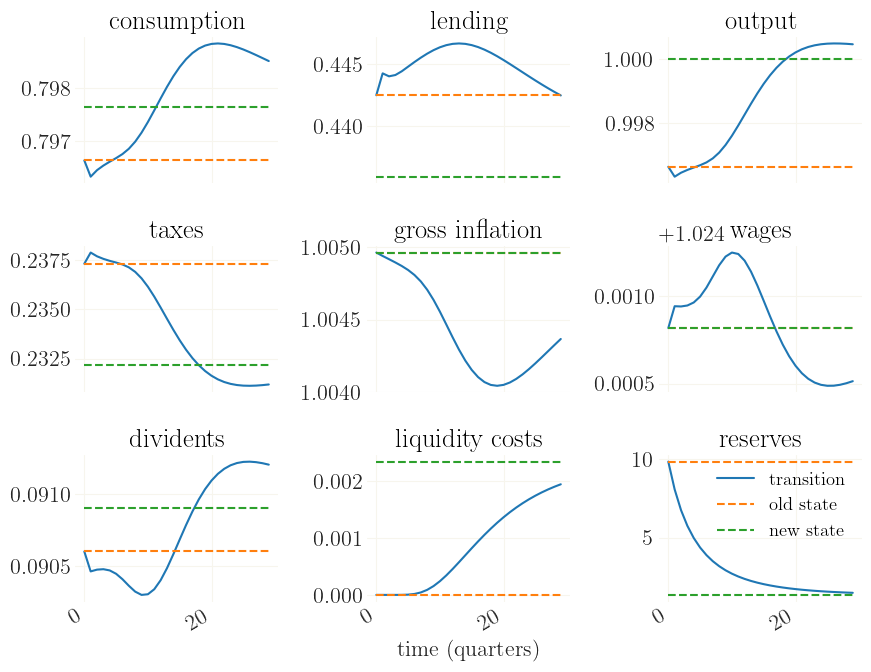

In [21]:
# choice of variables
choice = 'C', 'borr', 'y', 'tax', 'pi', 'w', 'div', 'bcost', 'J'
inds = [mod_ini.var_names.index(c) for c in choice]
labels = 'consumption', 'lending', 'output', 'taxes', 'gross inflation', 'wages', 'dividents', 'liquidity costs', 'reserves'
legend = 'transition', 'old state', 'new state'

# plot
figs, axs = figurator(3,3, figsize=(9,7))
pplot((xst[:30, inds], xstst_ini[:30, inds], xstst_tgt[:30, inds]), labels=labels, styles=('-', '--', '--'), ax=axs, legend=legend)
axs[-1].legend(framealpha=0)
axs[-2].set_xlabel('time (quarters)')
figs[0].tight_layout()

## Figure 7
This is more or less the same exercises as above, but with the MRR.

In [22]:
# parse model
mod_dict = ep.parse(path_yaml)
mod_dict['globals']['mrr'] = True
mod_dict['globals']['tax_distortion'] = tax_distortion

# compile model
mod = ep.load(mod_dict, raise_errors=True)
_ = mod.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.60e+00 | lapsed 4.0683
    Iteration   2 | max. error 4.45e-02 | lapsed 6.0527
    Iteration   3 | max. error 6.58e-04 | lapsed 7.9525
(solve_stst:) Steady state found (9.9781s). The solution converged.


In [23]:
# fix some steady state values
mod_dict['steady_state']['init_guesses']['Rj'] = mod_dict['steady_state']['fixed_values']['Rj']
mod_dict['steady_state']['init_guesses']['g2y'] = mod_dict['steady_state']['fixed_values']['g2y']
mod_dict['steady_state']['init_guesses']['seig2y'] = mod_dict['steady_state']['fixed_values']['seig2y']
mod_dict['steady_state']['init_guesses']['MPJ'] = mod_dict['steady_state']['fixed_values']['MPJ']
mod_dict['steady_state']['init_guesses']['bprof'] = mod_dict['steady_state']['fixed_values']['bprof']
mod_dict['steady_state']['init_guesses']['y'] = mod_dict['steady_state']['fixed_values']['y']
del mod_dict['steady_state']['fixed_values']['MPJ']
del mod_dict['steady_state']['fixed_values']['g2y']
del mod_dict['steady_state']['fixed_values']['seig2y']
del mod_dict['steady_state']['fixed_values']['bprof']
del mod_dict['steady_state']['fixed_values']['bcost2y']
del mod_dict['steady_state']['fixed_values']['y']

mod_dict['steady_state']['fixed_values']['gamma_log'] = mod.pars['gamma_log']
mod_dict['steady_state']['fixed_values']['nu_log'] = mod.pars['nu_log']
mod_dict['steady_state']['fixed_values']['div2equity'] = mod.pars['div2equity']
mod_dict['steady_state']['fixed_values']['g'] = mod.stst['g']
mod_dict['steady_state']['fixed_values']['omega'] = mod.pars['omega']
mod_dict['steady_state']['fixed_values']['z'] = mod.stst['z']

In [24]:
# get value of xi
xi = mod_dict['steady_state']['fixed_values']['xi']

# iterate over range
xs = jnp.linspace(xi,1,n)
res = ()

for x in tqdm.tqdm(xs):

    mod_dict['steady_state']['fixed_values']['xi'] = x
    # use last result as guess
    mod_dict['steady_state']['init_guesses'].update(mod['steady_state']['found_values'])

    # compile model
    mod = ep.load(mod_dict, raise_errors=True, verbose=False)
    # find steady state
    res_stst = mod.solve_stst(tol=1e-8, maxit=30, tol_forwards=1e-11, verbose=False)

    # store
    dist = mod['steady_state']['distributions'][0]
    values = mod['steady_state']['value_functions'][0]
    stst = mod.stst.values()

    res += (stst, dist, values),

100%|██████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.70s/it]


In [25]:
# extract results
bins, values_ut = (), ()
for x in res:
    binned_weight = x[1].sum(0).cumsum()
    binned_values = (x[1]*x[2]).sum(0).cumsum()
    bins_aggr = jnp.interp(jnp.linspace(0,1,4)[1:], binned_weight, binned_values)
    bins += jnp.diff(bins_aggr, prepend=0)*3,
    values_ut += jnp.sum(x[1]*x[2]),

bins = jnp.array(bins).T
stst = jnp.array([[*x[0]] for x in res])

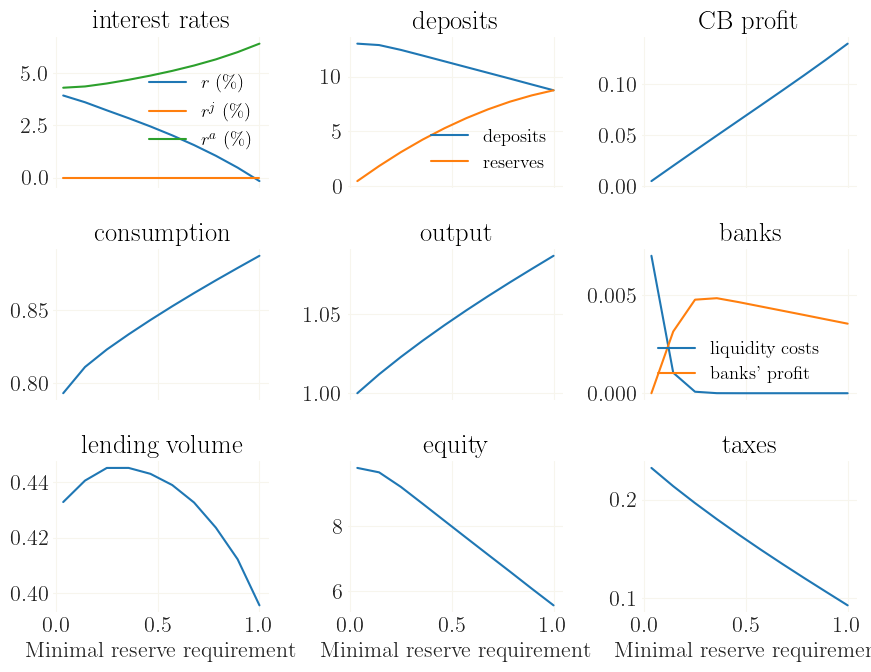

In [26]:
# plotting
fig, axs = plt.subplots(3, 3, figsize=(9,7), sharex='col')
axs[0,0].set_title('interest rates')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('R')]-1)*400, label='$r$ (\\%)')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('Rj')]-1)*400, label='$r^j$ (\\%)')
axs[0,0].plot(xs, (stst[:,mod.var_names.index('Ra')]-1)*400, label='$r^a$ (\\%)')
axs[0,0].legend(framealpha=0)
axs[0,1].set_title('deposits')
axs[0,1].plot(xs, stst[:,mod.var_names.index('depos')], label='deposits')
axs[0,1].plot(xs, stst[:,mod.var_names.index('J')], label='reserves')
axs[0,1].legend(framealpha=0)
axs[0,2].set_title("CB profit")
axs[0,2].plot(xs, stst[:,mod.var_names.index('seig')], label='CB profit')
axs[1,0].set_title('consumption')
axs[1,0].plot(xs, stst[:,mod.var_names.index('C')])
axs[1,1].set_title('output')
axs[1,1].plot(xs, stst[:,mod.var_names.index('y')])
axs[1,2].set_title("banks")
axs[1,2].plot(xs, stst[:,mod.var_names.index('bcost')], label='liquidity costs')
axs[1,2].plot(xs, stst[:,mod.var_names.index('bprof')], label="banks' profit")
axs[1,2].legend(framealpha=0)
axs[2,0].set_title('lending volume')
axs[2,0].plot(xs, stst[:,mod.var_names.index('borr')])
axs[2,1].set_title('equity')
axs[2,1].plot(xs, stst[:,mod.var_names.index('equity')])
axs[2,2].set_title('taxes')
axs[2,2].plot(xs, stst[:,mod.var_names.index('tax')])
axs[2,0].set_xlabel('Minimal reserve requirement')
axs[2,1].set_xlabel('Minimal reserve requirement')
axs[2,2].set_xlabel('Minimal reserve requirement')
fig.tight_layout()

## Figure 8
The figure also uses the simulations from Figure 9

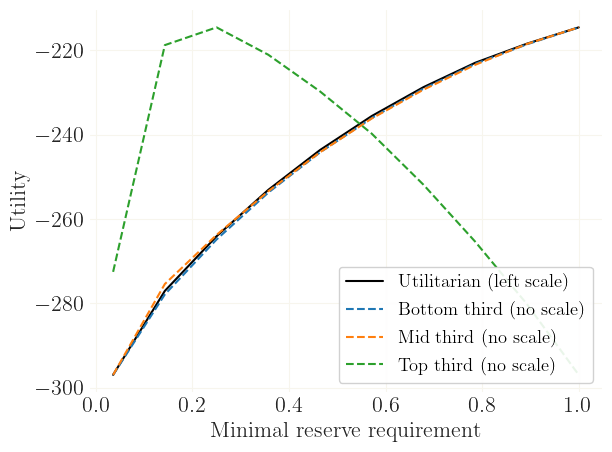

In [27]:
# more plotting
fig, ax = plt.subplots()
lns = ax.plot(xs, values_ut, c='k', label='Utilitarian (left scale)')[0],
legends = 'Bottom third (no scale)', 'Mid third (no scale)', 'Top third (no scale)'
for i,line in enumerate(bins):
    axx = ax.twinx()
    lns += axx.plot(xs, line, '--', c=f'C{i}', label=legends[i])[0],
    axx.set_yticks([])
ax.set_xlabel('Minimal reserve requirement')
ax.set_ylabel('Utility')
axx.legend(lns, [l.get_label() for l in lns], loc=4, framealpha=.9)
fig.tight_layout()

## Figure 9
For this figure we need 4 different model specifications

In [28]:
# parse model
mod_dict = ep.parse(path_yaml)

# compile calibrated model & find stst
mod_clb = ep.load(mod_dict, raise_errors=True)
_ = mod_clb.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 4.90e-01 | lapsed 4.2130
    Iteration   2 | max. error 2.47e-03 | lapsed 6.5061
    Iteration   3 | max. error 3.52e-07 | lapsed 8.7119
(solve_stst:) Steady state found (11.102s). The solution converged.


In [29]:
# fix some steady state values
mod_dict['steady_state']['init_guesses']['Rj'] = mod_dict['steady_state']['fixed_values']['Rj']
mod_dict['steady_state']['init_guesses']['g2y'] = mod_dict['steady_state']['fixed_values']['g2y']
mod_dict['steady_state']['init_guesses']['seig2y'] = mod_dict['steady_state']['fixed_values']['seig2y']
mod_dict['steady_state']['init_guesses']['bprof'] = mod_dict['steady_state']['fixed_values']['bprof']
mod_dict['steady_state']['init_guesses']['y'] = mod_dict['steady_state']['fixed_values']['y']
del mod_dict['steady_state']['fixed_values']['Rj']
del mod_dict['steady_state']['fixed_values']['g2y']
del mod_dict['steady_state']['fixed_values']['seig2y']
del mod_dict['steady_state']['fixed_values']['bprof']
del mod_dict['steady_state']['fixed_values']['bcost2y']
del mod_dict['steady_state']['fixed_values']['y']

mod_dict['steady_state']['fixed_values']['MPJ'] = 0
mod_dict['steady_state']['fixed_values']['gamma_log'] = mod_clb.pars['gamma_log']
mod_dict['steady_state']['fixed_values']['nu_log'] = mod_clb.pars['nu_log']
mod_dict['steady_state']['fixed_values']['div2equity'] = mod_clb.pars['div2equity']
mod_dict['steady_state']['fixed_values']['g'] = mod_clb.stst['g']
mod_dict['steady_state']['fixed_values']['omega'] = mod_clb.pars['omega']
mod_dict['steady_state']['fixed_values']['z'] = mod_clb.stst['z']

In [30]:
# compile "current" excess reserves model & find stst
mod_dict['steady_state']['fixed_values']['Jex'] = 20
mod_cur = ep.load(mod_dict, raise_errors=True)
_ = mod_cur.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.90e+01 | lapsed 4.2763
    Iteration   2 | max. error 2.23e+00 | lapsed 6.6766
    Iteration   3 | max. error 2.20e-01 | lapsed 9.0209
    Iteration   4 | max. error 1.83e-03 | lapsed 11.3425
    Iteration   5 | max. error 9.99e-07 | lapsed 13.3755
(solve_stst:) Steady state found (15.481s). The solution converged.


In [31]:
# compile optimal excess reserves model & find stst
mod_dict['steady_state']['fixed_values']['Jex'] = 2.8331129901417342
mod_opt = ep.load(mod_dict, raise_errors=True)
_ = mod_opt.solve_stst(tol=1e-8, maxit=20, tol_forwards=1e-11)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 1.83e+00 | lapsed 4.4616
    Iteration   2 | max. error 4.10e-02 | lapsed 6.6435
    Iteration   3 | max. error 2.47e-03 | lapsed 8.7213
    Iteration   4 | max. error 3.38e-07 | lapsed 10.8689
(solve_stst:) Steady state found (13.06s). The solution converged.


In [32]:
# compile chicago plan model
mod_dict['steady_state']['init_guesses']['MPJ'] = mod_dict['steady_state']['fixed_values']['MPJ']
del mod_dict['steady_state']['fixed_values']['MPJ']
mod_dict['steady_state']['fixed_values']['Jex'] = 1
mod_dict['steady_state']['fixed_values']['Rj'] = 1

# find steady state using annealing
mod_mrr, mod_dict = ep.tools.anneal_stst(mod_dict, ('steady_state', 'fixed_values', 'xi'), 1, tol=1e-8, tol_forwards=1e-11, maxit=10)

(anneal_stst:) 1 value(s) in queue. Trying xi=1...
    Iteration   1 | max. error 9.64e-01 | lapsed 3.9565
    Iteration   2 | max. error 9.57e+00 | lapsed 5.4654
Steady state FAILED (max. error is 9.03e+01 in eqn. 2). The Jacobian contains NaNs. Adding value to queue.
(anneal_stst:) 2 value(s) in queue. Trying xi=0.518...
    Iteration   1 | max. error 9.43e-01 | lapsed 3.6076
    Iteration   2 | max. error 2.26e+00 | lapsed 6.6287
    Iteration   3 | max. error 1.24e+00 | lapsed 8.5156
    Iteration   4 | max. error 3.12e-02 | lapsed 10.4016
    Iteration   5 | max. error 2.99e-05 | lapsed 12.3251
(solve_stst:) Steady state found (14.221s). The solution converged.
(anneal_stst:) Success with 0.518! Guesses updated...
    queue is (1,)
(anneal_stst:) 1 value(s) in queue. Trying xi=1...
    Iteration   1 | max. error 4.82e-01 | lapsed 3.5885
    Iteration   2 | max. error 6.42e-01 | lapsed 5.4035
    Iteration   3 | max. error 6.45e-03 | lapsed 7.2221
    Iteration   4 | max. error 1.0

In [33]:
# get distributions and values
batch = (mod_clb['steady_state']['distributions'][0], mod_clb['steady_state']['value_functions'][0]),
batch += (mod_cur['steady_state']['distributions'][0], mod_cur['steady_state']['value_functions'][0]),
batch += (mod_opt['steady_state']['distributions'][0], mod_opt['steady_state']['value_functions'][0]),
batch += (mod_mrr['steady_state']['distributions'][0], mod_mrr['steady_state']['value_functions'][0]),

# define shocks/initial state
nbins = 20
bins, values_ut = (), ()
a_grid = mod_clb['context']['a_grid']

In [34]:
# define helper functions
tolifetime = lambda V: ((1-mod_clb.stst['beta'])*(1-mod_clb.pars['sigma_c'])*V)**(1/(1-mod_clb.pars['sigma_c']))

def get_vals(batch):
    dist, vals = batch
    vals = tolifetime(vals)
    inds = jnp.argsort(vals.flatten())
    dist_sorted = dist.flatten()[inds]
    cdf = jnp.cumsum(dist_sorted)/dist_sorted.sum()
    vals_sorted = vals.flatten()[inds]
    return cdf, vals_sorted

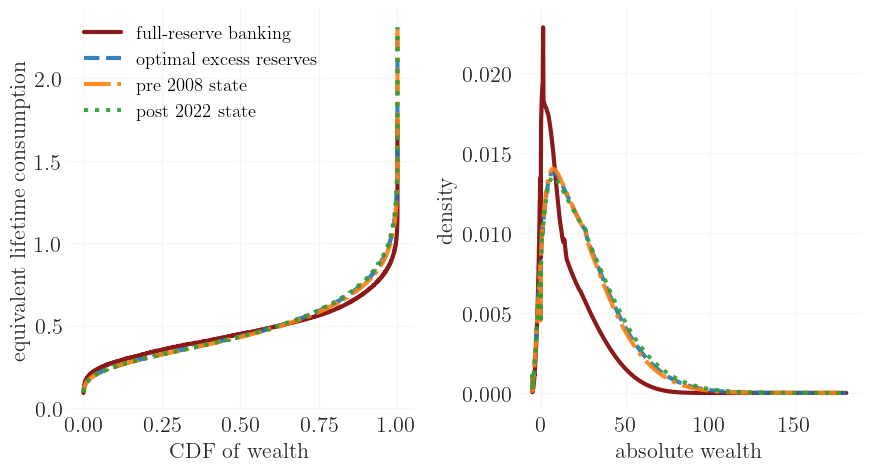

In [35]:
# plotting
fig, axs = plt.subplots(1,2, figsize=(9,5))
axs[0].plot(*get_vals(batch[3]), alpha=0.9, lw=3, label='full-reserve banking', c='maroon')
axs[0].plot(*get_vals(batch[2]), '--', alpha=0.9, lw=3, label='optimal excess reserves')
axs[0].plot(*get_vals(batch[0]), '-.', alpha=0.9, lw=3, label='pre 2008 state')
axs[0].plot(*get_vals(batch[1]), ':', alpha=0.9, lw=3, label='post 2022 state')
axs[0].set_ylabel('equivalent lifetime consumption')
axs[0].set_xlabel('CDF of wealth')
axs[0].legend(framealpha=0)
axs[1].plot(a_grid, batch[3][0].sum(0), alpha=0.9, lw=3, c='maroon')
axs[1].plot(a_grid, batch[2][0].sum(0), '--', alpha=0.9, lw=3)
axs[1].plot(a_grid, batch[0][0].sum(0), '-.', alpha=0.9, lw=3)
axs[1].plot(a_grid, batch[1][0].sum(0), ':', alpha=0.9, lw=3)
axs[1].set_ylabel('density')
axs[1].set_xlabel('absolute wealth')
fig.tight_layout()